# MixingSupressionByMeanflow

In [1]:
# TODO
# - Merge the mean flow into the aviso vel file (also update BuseckeAbernathey2018Analysis)
# - Finish the area recreation and save a clean velocity file.

In [2]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xarrayutils.utils import composite
%matplotlib inline

In [3]:
ddir = '/rigel/home/jb3210/jb3210/projects/aviso_products/output_dir'

In [4]:
# load the prototype results
koc_path = '/rigel/home/jb3210/jb3210/projects/aviso_surface_tracer/output/prototype_tracer_variance_output.nc' 
ds_koc = xr.open_dataset(koc_path, engine='scipy')
ds_koc = ds_koc.where(abs(ds_koc.YC) > 5)
ds_koc

<xarray.Dataset>
Dimensions:            (XC: 360, YC: 160, time: 98, tracer: 4, tracer_no: 2)
Coordinates:
  * XC                 (XC) float32 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 ...
    rA                 (YC, XC) float32 ...
    Depth              (YC, XC) float32 ...
    hFacC              (YC, XC) float32 ...
  * YC                 (YC) float32 -79.95 -78.95 -77.95 -76.95 -75.95 ...
  * time               (time) datetime64[ns] 1993-03-02 1993-05-31 ...
  * tracer             (tracer) object 'PSI' 'LAT' 'SST' 'SSS'
  * tracer_no          (tracer_no) int32 1 2
Data variables:
    kmin               (time, YC, XC) float64 nan nan nan nan nan nan nan ...
    lmixmin            (time, YC, XC) float64 nan nan nan nan nan nan nan ...
    production         (time, tracer, tracer_no, YC, XC) float64 nan nan nan ...
    dissipation        (time, tracer, tracer_no, YC, XC) float64 nan nan nan ...
    qbar_variance      (time, tracer, tracer_no, YC, XC) float64 nan nan nan ...
    qp_varia

<xarray.Dataset>
Dimensions:    (XC: 360, YC: 160, time: 289)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 1993-03-01 ...
  * YC         (YC) float64 -79.95 -78.95 -77.95 -76.95 -75.95 -74.95 -73.95 ...
  * XC         (XC) float64 0.05 1.05 2.05 3.05 4.05 5.05 6.05 7.05 8.05 ...
Data variables:
    eke        (time, YC, XC) float32 ...
    ubar       (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...
    vbar       (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...
    eke_corr   (time, YC, XC) float32 ...
    ubar_corr  (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...
    vbar_corr  (time, YC, XC) float32 nan nan nan nan nan nan nan nan nan ...

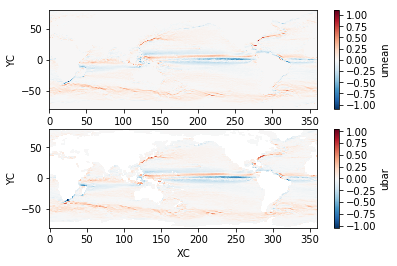

In [5]:
vel_file = os.path.join(ddir, 'prototype_combined_eke_large_scale.nc')
ds_vel = xr.open_dataset(vel_file)

# I forgot to add the actual time mean flow (I should do this in the separate processing file once this gets cleaned up)
mean_file = os.path.join(ddir, 'prototype_time_mean.nc')
# Why do I need scipy for this to work?
ds_vel_mean = xr.open_dataset(mean_file)#, engine='scipy')

ds_vel_raw = ds_vel.copy()

# Insert mean variables into ds_mean
ds_vel['ubar'] = ds_vel['ubar'] + ds_vel_mean['umean']
ds_vel['vbar'] = ds_vel['vbar'] + ds_vel_mean['vmean']

ds_vel['ubar_corr'] = ds_vel['ubar_corr'] + ds_vel_mean['umean_corr']
ds_vel['vbar_corr'] = ds_vel['vbar_corr'] + ds_vel_mean['vmean_corr']

plt.subplot(2,1,1)
ds_vel_mean['umean'].plot()

plt.subplot(2,1,2)
ds_vel['ubar'].mean('time').plot()

ds_vel

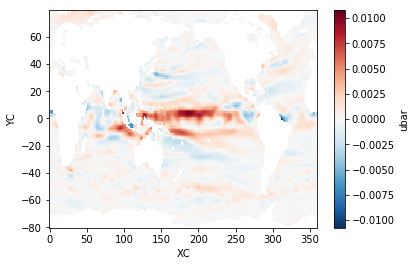

In [6]:
ds_vel_raw['ubar'].mean('time').plot()

In [7]:
# # reconstruct the area for area weighting
# from xgcm.autogenerate import generate_grid_ds

# ds_vel = generate_grid_ds(ds_vel, )

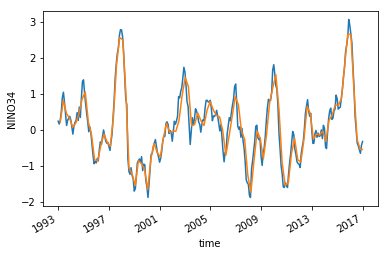

In [8]:
# Load ENSO index (TODO maybe update befor the final release)
ENSO_raw = xr.open_dataset('/rigel/home/jb3210/jb3210/shared_data/climate_indicies/ENSO.nc')
ENSO = ENSO_raw.resample(time='1M').mean().reindex_like(ds_vel, method='nearest') #TODO not sure if this is the best for the correlation...ask Ryan...the signal should be strong anyways
ENSO_koc = ENSO_raw.resample(time='3M').mean().reindex_like(ds_koc, method='nearest')
ENSO.NINO34.plot()
ENSO_koc.NINO34.plot()
# Can I apply reindex with interpolation?

In [ ]:
# # Load the AGVA velocities
# upath = '/rigel/home/jb3210/jb3210/shared_data/AGVA/derived/u_time_pressure_mean.nc'
# vpath = '/rigel/home/jb3210/jb3210/shared_data/AGVA/derived/v_time_pressure_mean.nc'
# rename = {'longitude': 'XC', 'latitude':'YC'}
# U_tz = xr.open_dataarray(upath).rename(rename).reindex_like(ds_vel, method='nearest')
# V_tz = xr.open_dataarray(vpath).rename(rename).reindex_like(ds_vel, method='nearest')

# Load the ECCo velocities
eccopath = '/rigel/home/jb3210/jb3210/shared_data/ECCO/derived/ECCO_v4_r2_vel_time_depth_mean.nc'
rename = {'lon': 'XC', 'lat':'YC'}
ECCO = xr.open_dataset(eccopath)
U_tz = ECCO.EVELMASS.rename(rename).reindex_like(ds_vel, method='nearest')
V_tz = ECCO.NVELMASS.rename(rename).reindex_like(ds_vel, method='nearest')


U_tz.plot(robust=True)
plt.figure()
V_tz.plot(robust=True)

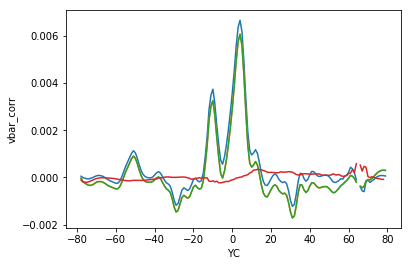

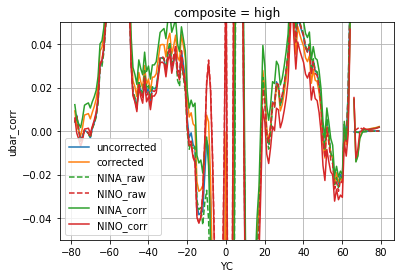

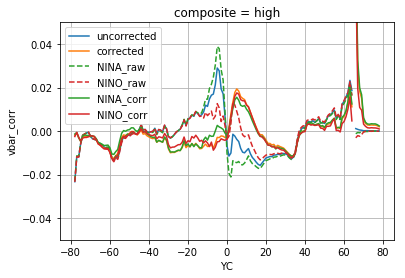

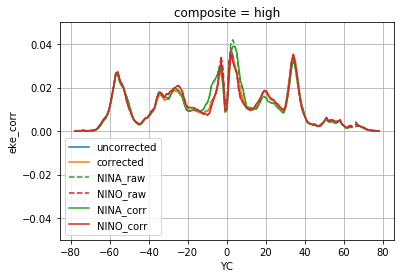

In [9]:
# sector_kw = dict(XC=slice(180,230))
sector_kw = dict(XC=slice(150,250))
sector = ds_vel.sel(**sector_kw).mean('XC')
sector_raw = ds_vel_raw.sel(**sector_kw).mean('XC')
sector_koc = ds_koc.sel(**sector_kw).mean('XC')
sector_mean = sector.mean('time')

sector_koc_comp = composite(sector_koc, ENSO_koc.NINO34, [-1,1]).mean('time')
sector_comp = composite(sector, ENSO.NINO34, [-1,1]).mean('time')

sector_trend = sector_raw.mean('time')

sector_trend['ubar'].plot()
sector_trend['ubar_corr'].plot()

sector_trend['ubar_corr'].plot()
sector_trend['vbar_corr'].plot()

for va in ['ubar', 'vbar', 'eke']:
    plt.figure()
    sector_mean[va].plot()
    sector_mean[va+'_corr'].plot()
    sector_comp[va].sel(composite='low').plot(color='C2',
                                             linestyle='--')
    sector_comp[va].sel(composite='high').plot(color='C3',
                                               linestyle='--')
    
    sector_comp[va+'_corr'].sel(composite='low').plot(color='C2')
    sector_comp[va+'_corr'].sel(composite='high').plot(color='C3')
    plt.gca().set_ylim([-0.05, 0.05])
    plt.grid()
    plt.legend(['uncorrected', 'corrected',
                'NINA_raw', 'NINO_raw',
                'NINA_corr', 'NINO_corr'])

# Evaluate the supression factor

From Mixing Length Theory:

$ K =  \Gamma \, L_{mix} \, u_{rms} $

The formula for the mixing supression is:

$ L_{mix} = \frac{L}{1 + \alpha (U-c)^2} $

or alternatively

$ K = \frac{K_0}{1+ \alpha (U-c)^2} $

with $K_0 = \Gamma u_{rms} L$

with 

$c_x = U_{zt} - \beta L_D^2$ 
The zonal eddy propagation speed

$c_y = V_{zt} $
The meridonal eddy propagation speed

$\alpha = \frac{k^2}{\gamma^2}$

$ u_{rms} = \sqrt{2 EKE} $

$ k = \frac{2\pi}{L} $

$ \gamma = 1e^{-6}$ s (estimated in Klocker and Abernathey 14)

$ L $ = Observed lengthscale of eddies (I get the radius from Chelton from Ryan)

$\Gamma = 0.2 $ (in the newest version determined by inverting for it)

# Inversion for Gamma

In the calculation for $K_{mix}$, two parameters are chosen somewhat randomly. Namely the mixing efficiency $\Gamma$ ('order one constant')
and the eddy decay time scale $\gamma$ (in KA14 a 'best fit' is presented of 1/4days).

In the following cell I will use our two independent estimates of minimum diffusivity to invert for $Gamma$. I chose to use the physically based expression of $\gamma = \frac{u_{rms}}{2\Gamma L_{obs}}$ for the eddy decay timescale.

By assuming the two diffusivites are equal:

$K_{min} = K_{mix_min} = \frac{\Gamma L_{obs} u_{rms}}{1 + \frac{2 \Gamma L_{obs} k^{2} {(U-c)}^{2}}{u_{rms}}}$

We can solve for $\Gamma$:

$ \Gamma = - \frac{K_{min} u_{rms}}{2 K_{min} L_{obs} k^{2} speed_{diff}^{2} - L_{obs} u_{rms}^{2}} $



NameError: name 'Gamma' is not defined

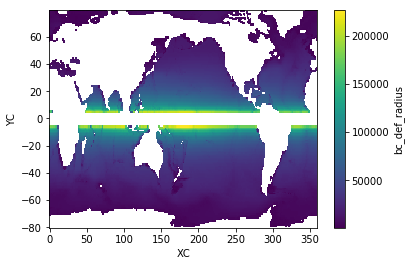

In [14]:
# Load all relevant files

u_rms = xr.ufuncs.sqrt(2*sector['eke_corr'].mean('time'))
u_rms.name = 'u_rms'

L_D = xr.open_dataset('/rigel/home/jb3210/jb3210/shared_data/rossby_radius/first_baroclinc_mode.nc')
L_D = L_D['bc_def_radius'].rename({'lat':'YC', 'lon':'XC'}).reindex_like(ds_vel, method='nearest')
L_D.plot()

#L
ch_eddystats = xr.open_dataset('/rigel/home/jb3210/jb3210/projects/aviso_surface_tracer/data/chelton_eddy_stats_180-230.nc')
L_obs = ch_eddystats.radius.rename({'lat':'YC'}).reindex_like(ds_vel, method='nearest')*1e3
L_obs.name = 'observed eddy radius'
# beta
omega=2*np.pi/(24*60*60) # consistent with tabularized value
R = 6.371*1e6
ref_da = ds_vel.mean(['time', 'XC'])
beta = xr.DataArray(2.0*omega*np.cos(np.deg2rad(ds_vel.YC))/R,
                    dims=ref_da.dims,
                    coords=ref_da.coords,
                    name='beta')
# k
k = 2*np.pi/L_obs
k.name = 'k'

# This is the unexplained 'best fit' from KA14
gamma = xr.DataArray(1/(4*24*60*60))

# This is a physically based scale (I think from the Ferrari and Nikurashin paper)
gamma = u_rms/ (2 * Gamma * L_obs)
gamma.name = 'gamma'

gamma_inv = 1 / gamma / 86400

# alpha
alpha = (k**2) / (gamma**2)
alpha.name = 'alpha'

# phase speed
# c = 2*beta*(L**2)
# c.name = 'c'
theoretical_c = - beta * (L_D**2)
theoretical_c.name = 'theory phase speed'

c_x = U_tz + theoretical_c
c_x.name = 'c_x'

c_y = V_tz
c_y.name = 'c_y'

c = c_x.sel(**sector_kw).mean('XC')
# c = c_y.sel(**sector_kw).mean('XC')
c.name = 'c'

plt.figure(figsize=[14,12])
for ni, data in enumerate([L, L_D, gamma_inv, beta, k, alpha, theoretical_c, c_x, c_y]):
    plt.subplot(5,2,1+ni)
    if 'XC' in data.dims:
        data = data.sel(**sector_kw).mean('XC')
    data.plot()
    plt.grid()
plt.subplots_adjust(hspace=0.6)

In [10]:
# ds_supression_invert = ds_supression.reindex_like(K_min, method='nearest')
K_min = ds_koc['kmin']
# u_rms = ds_supression_invert['u_rms']
L_obs = ds_supression_invert['L'] # Check if this is actually the correct radius
# k = ds_supression_invert['k']
speed_diff = xr.ufuncs.minimum(ds_supression_invert['speed_diff_x'], ds_supression_invert['speed_diff_y']) # This is the min speed diff (the only parameter that captured x-y dependence)
Gamma_inverted = (K_min * u_rms) / ((L_obs * u_rms**2) + (2 * K_min * L_obs * k**2 * speed_diff**2))# Invert for Gamme (mixing efficiency)


# set clipped values to different color
cmap= plt.cm.inferno
cmap.set_over('g')
cmap.set_under('c')
plt.figure(figsize = [14, 10])
plt.subplot(2,2,1)
Gamma_inverted.plot(bins=np.linspace(0,1.5,35))
plt.axvline(Gamma_inverted.mean(), color='0.5')

plt.subplot(2,2,2)
Gamma_inverted.mean('time').plot(vmax=0.7, vmin=0.05, cmap=cmap)
plt.title('Inverted Gamma time mean')

plt.subplot(2,2,3)
Gamma_inverted.std('time').plot(vmax=0.25, cmap=cmap)
plt.title('Inverted Gamma time std')

plt.subplot(2,2,4)
(Gamma_inverted.std('time') / Gamma_inverted.mean('time')).plot(vmax=1, vmin=0, cmap = plt.cm.RdBu_r)
plt.title('Ratio of std/mean')

plt.suptitle('Mixing efficiency inverted From $K_{min} \Gamma / K_{mix}$', usetex=True);

NameError: name 'ds_supression' is not defined

In [ ]:

# Gamma = 0.2

Gamma = Gamma_inverted.mean('time')

In [ ]:
# Compare L values to KA14
L_D.sel(**sector_kw).mean('XC').plot(label='L_D')
L.plot(label='L_obs')
plt.ylabel('')
plt.legend()

In [ ]:
c_x.sel(**sector_kw).mean('XC').plot(label='Doppler shifted zonal phase speed')
theoretical_c.sel(**sector_kw).mean('XC').plot(label='theoretical zonal phase speed')
plt.legend()
plt.axhline(-0.05)
plt.axvline(-20)

In [ ]:
gamma_inv.plot()
plt.gca().set_ylim([0,5])

In [ ]:
u_rms.plot()
sector['ubar'].mean(['time']).plot()
c.plot()
plt.legend(['u_rms', 'u_bar', 'c_w'])
plt.figure()
(1 / (1 + (alpha *((sector['ubar'].mean(['time'])-c)**2)))).plot()

In [ ]:
# For the mean case 
L_mix = L / (1 + (alpha * (sector['ubar'].mean(['time'])-c)**2))
L_mix_corr = L / (1 + (alpha * ((sector['ubar_corr'].mean(['time'])-c)**2)))
K = 0.2 * L_mix * u_rms
K_corr = 0.2 * L_mix_corr * u_rms
K_0 = 0.2 * L *u_rms

plt.figure(figsize=[6, 10])
plt.subplot(2,1,1)
L_mix.where(abs(L_mix.YC) > 15).plot()
L_mix_corr.where(abs(L_mix.YC) > 15).plot()
(sector_koc['lmixmin']/2).mean('time').plot()
L.where(abs(L_mix.YC) > 15).plot()
plt.title('L_mix [m]')
plt.legend(['uncorrected', 'divergence corrected', 'diagnosed from tracer experiment', 'unsupressed'])



plt.subplot(2,1,2)
K.where(abs(K.YC) > 15).plot()
K_corr.where(abs(K.YC) > 15).plot()
(sector_koc['kmin']).mean('time').plot()
K_0.where(abs(K.YC) > 15).plot()
plt.title('K [$m^2/s$]')
plt.subplots_adjust(hspace=0.4)

# Do this plot for various kernel sizes (in the mean_EKE decomp)

In [ ]:
# Now for the ENSO composites (keeping EKE constant)
u = sector_comp.where(abs(sector_comp.YC) > 15)

L_mix = L / (1 + (alpha * (u['ubar']-c)**2))
L_mix_corr = L / (1 + (alpha * (u['ubar_corr']-c)**2))
K = 0.2 * L_mix * u_rms
K_corr = 0.2 * L_mix_corr * u_rms

plt.figure(figsize=[8, 8])
plt.subplot(2,1,1)
L_mix_corr.sel(composite='high').plot(color='C3')
L_mix_corr.sel(composite='low').plot(color='C0')
(sector_koc_comp['lmixmin']).sel(composite='high').plot(color='k')
(sector_koc_comp['lmixmin']).sel(composite='low').plot(color='k', linestyle='--')
plt.legend(['Formula NINO', 'Formula NINA', 'Diagnosed NINO', 'Diagnosed NINA'])
plt.title('L_mix [m]')


plt.subplot(2,1,2)
K_corr.sel(composite='high').plot(color='C3')
K_corr.sel(composite='low').plot(color='C0')
(sector_koc_comp['kmin']).sel(composite='high').plot(color='k')
(sector_koc_comp['kmin']).sel(composite='low').plot(color='k', linestyle='--')
plt.title('K [$m^2/s$]')
plt.subplots_adjust(hspace=0.4)
plt.legend(['Formula NINO', 'Formula NINA', 'Diagnosed NINO', 'Diagnosed NINA'])

# Recreate the spatial maps

In [ ]:
ds_supression = xr.Dataset()
ds_supression['u_rms'] = xr.ufuncs.sqrt(2*ds_vel['eke_corr'].mean('time'))
# ds_supression['u_rms'] = xr.ufuncs.sqrt(2*ds_vel['eke_corr'])
ds_supression['u_bar'] = ds_vel['ubar_corr']
ds_supression['v_bar'] = ds_vel['vbar_corr']
ds_supression['L'] = L
ds_supression['L_D'] = L_D
ds_supression['K_0'] = Gamma * ds_supression['u_rms'] * ds_supression['L']

ds_supression['k'] = k
ds_supression['speed_diff_x'] = (c_x-ds_supression['u_bar'])**2
ds_supression['speed_diff_y'] = (c_y-ds_supression['v_bar'])**2
ds_supression['sup_fac_x'] = 1 / (1 + (alpha * ds_supression['speed_diff_x']))
ds_supression['sup_fac_y'] = 1 / (1 + (alpha * ds_supression['speed_diff_y']))
ds_supression['L_mix_x'] = L * ds_supression['sup_fac_x']
ds_supression['L_mix_y'] = L * ds_supression['sup_fac_y']
ds_supression['K_mix_x'] = ds_supression['K_0'] * ds_supression['sup_fac_y']
ds_supression['K_mix_y'] = ds_supression['K_0'] * ds_supression['sup_fac_x']
ds_supression['K_mix_min'] = xr.ufuncs.minimum(ds_supression['K_mix_x'],ds_supression['K_mix_y'])

In [ ]:
ds_supression_mean = ds_supression.mean('time')
plt.figure(figsize=[26,20])
for vi,vv in enumerate(list(ds_supression.data_vars)):
    if vv not in  ['L', 'k']:
        print(vv)
        data = ds_supression_mean[vv]
        plt.subplot(4,4,vi+1)
        data.plot(robust=True)

In [ ]:
ds_supression_mean = ds_supression.mean('time')
plt.figure(figsize=[26,20])
vi=0
for vv in list(ds_supression.data_vars):
    if 'time' in ds_supression[vv].dims:
        data = ds_supression[vv]
        data_comp = composite(data, ENSO.NINO34, [-0.5, 0.5]).mean('time')
        data_comp_an = data_comp-data.mean('time')
        plt.subplot(4,4,vi+1)
        data_comp_an.sel(composite='high').plot(robust=True)
        plt.title('%s composite ENSO+' %vv)
        vi += 1

In [ ]:
ds_supression

In [ ]:
ds_supression.load().to_netcdf('../output/prototype_mixing_supression.nc', engine='scipy')

In [ ]:
# Possible reasons for the mismatch in the sector
- EKE is variable and needs to be evaluated with velocity and then averaged
- Gamma variations
- gamma variations
- non realistic phase speeds (check with chelton dataset)